In [2]:
import os
import sys

current_dir =  os.getcwd()
#parent_dir = os.path.dirname(current_dir)
#sys.path.insert(0, parent_dir)

grandparent_dir = os.path.dirname(os.path.dirname(current_dir))
sys.path.insert(0, grandparent_dir)


import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

In [ ]:
from cities.utils import DataGrabber
data = DataGrabber()
data.get_gdp_wide()
gdp = data.gdp_wide
display(gdp.head())
print(gdp.shape)

In [102]:
transport = pd.read_csv(f"{grandparent_dir}/data/raw/smartLocationSmall.csv")


In [72]:
print(len(transport['GeoFIPS'].unique()))
print(transport['GeoFIPS'].unique())


3233
[ 1001  1003  1005 ... 78010 78020 78030]


In [103]:
# creating road density variable for the counties
# miles/suqare miles

transport = transport[['GeoFIPS', 'D3A']]

assert transport.isna().sum().sum() == 0
assert transport['GeoFIPS'].is_unique

display(transport)



,GeoFIPS,D3A
0,1001,1.981182
1,1003,2.484343
2,1005,1.457892
3,1007,1.926318
4,1009,2.808981
...,...,...
3228,72151,5.532236
3229,72153,7.031682
3230,78010,10.079970
3231,78020,5.880818


In [8]:
common_fips = np.intersect1d(roadDens['GeoFIPS'].unique(), gdp['GeoFIPS'].unique())
filtered_roadDens = roadDens[roadDens['GeoFIPS'].isin(common_fips)]
filtered_roadDens.reset_index()

print(filtered_roadDens.shape[0])
print(gdp.shape[0])

3055
3079


In [119]:
from cities.utils.data_grabber import DataGrabber
data = DataGrabber()
data.get_features_wide(['gdp'])
gdp = data.wide

In [117]:
gdp

{'gdp':       GeoFIPS         GeoName     2001     2002     2003     2004     2005  \
 0        1001     Autauga, AL   59.839   61.996   63.508   73.730   75.307   
 1        1003     Baldwin, AL   73.853   77.273   81.570   90.523  101.402   
 2        1005     Barbour, AL  113.864  111.853  114.628  124.473  125.004   
 3        1007        Bibb, AL   80.443   81.527   85.124   89.317   88.782   
 4        1009      Blount, AL   92.104   92.593   95.469   98.129  100.918   
 ...       ...             ...      ...      ...      ...      ...      ...   
 3101    56037  Sweetwater, WY   92.340   81.094   83.237   84.315   89.539   
 3102    56039       Teton, WY   81.931   84.886   85.316   86.359   88.884   
 3103    56041       Uinta, WY   99.906  110.550  107.053  108.929  112.808   
 3104    56043    Washakie, WY   92.187   91.281   95.083   95.411   91.317   
 3105    56045      Weston, WY   84.650   81.649   85.586   86.752   95.448   
 
          2006     2007     2008  ...     2

In [78]:
# for gdp

common_fips = np.intersect1d(gdp['GeoFIPS'].unique(), transport['GeoFIPS'].unique())
gdp = gdp[gdp['GeoFIPS'].isin(common_fips)]
assert len(common_fips) == len(gdp['GeoFIPS'].unique())
assert len(transport) > 3000, 'The number of records is lower than 3000'

In [104]:
# for transport

common_fips = np.intersect1d(gdp['GeoFIPS'].unique(), transport['GeoFIPS'].unique())
transport = transport[transport['GeoFIPS'].isin(common_fips)]
assert len(common_fips) == len(transport['GeoFIPS'].unique())
assert len(transport) > 3000, 'The number of records is lower than 3000'

In [105]:
# transport creating GeoName column

transport = transport.merge(gdp[['GeoFIPS', 'GeoName']],
                            on='GeoFIPS', how='left')[['GeoFIPS', 'GeoName', 'D3A']]


patState = r', [A-Z]{2}(\*{1,2})?$'
GeoNameError = 'Wrong Geoname value!'
assert transport['GeoName'].str.contains(patState, regex=True).all(), GeoNameError
assert sum(transport['GeoName'].str.count(', ')) == transport.shape[0], GeoNameError


C:\Users\nikod\AppData\Local\Temp\ipykernel_9384\1115834462.py:9: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  assert transport['GeoName'].str.contains(patState, regex=True).all(), GeoNameError


In [106]:
transport

,GeoFIPS,GeoName,D3A
0,1001,"Autauga, AL",1.981182
1,1003,"Baldwin, AL",2.484343
2,1005,"Barbour, AL",1.457892
3,1007,"Bibb, AL",1.926318
4,1009,"Blount, AL",2.808981
...,...,...,...
3050,56037,"Sweetwater, WY",0.688244
3051,56039,"Teton, WY",0.524244
3052,56041,"Uinta, WY",1.008798
3053,56043,"Washakie, WY",0.757877


C:\Users\nikod\AppData\Local\Temp\ipykernel_9384\914393803.py:7: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  assert merged_df['GeoName'].str.contains(patState, regex=True).all(), GeoNameError


,GeoFIPS,GeoName,D3A
0,1001,"Autauga, AL",1.981182
1,1003,"Baldwin, AL",2.484343
2,1005,"Barbour, AL",1.457892
3,1007,"Bibb, AL",1.926318
4,1009,"Blount, AL",2.808981
...,...,...,...
3050,56037,"Sweetwater, WY",0.688244
3051,56039,"Teton, WY",0.524244
3052,56041,"Uinta, WY",1.008798
3053,56043,"Washakie, WY",0.757877


C:\Users\nikod\AppData\Local\Temp\ipykernel_9384\3755139959.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  assert merged_df['GeoName'].str.contains(patState, regex=True).all()


,GeoFIPS,GeoName,D3A
71,2158,"Kusilvak Census Area, AK*",0.029918
75,2282,"Yakutat City and Borough, AK*",0.032772
224,8001,"Adams, CO*",3.500227
230,8013,"Boulder, CO*",3.764204
253,8059,"Jefferson, CO*",5.800541
285,8123,"Weld, CO*",2.124074
2386,46102,"Oglala Lakota, SD*",0.806249
2800,51019,"Bedford, VA*",3.052274


{15901, 51901, 51903, 51907, 51911, 51913, 51918, 51919, 51921, 51923, 51929, 51931, 51933, 51939, 51941, 51942, 51944, 51945, 51947, 51949, 51951, 51953, 51955, 51958}
{69120, 2050, 51720, 2060, 51730, 2070, 51735, 51740, 51750, 2090, 51760, 2100, 2105, 51770, 2110, 51775, 51790, 2130, 51800, 51810, 2150, 60010, 51820, 60020, 51830, 2170, 60030, 51840, 2180, 60040, 60050, 2195, 2198, 15005, 15009, 2220, 2230, 78010, 2240, 78020, 78030, 2261, 2275, 2290, 32510, 51510, 51003, 51005, 51520, 72001, 72003, 72005, 29510, 51015, 72007, 72009, 51530, 72011, 72013, 8014, 72015, 72017, 72019, 51540, 72021, 51031, 72023, 72025, 51035, 72027, 72029, 51550, 72031, 72033, 72035, 72037, 72039, 72041, 72043, 51053, 72045, 72047, 72049, 51570, 51059, 72051, 72053, 72054, 72055, 72057, 72059, 51580, 51069, 72061, 72063, 72065, 72067, 72069, 51590, 72071, 51081, 72073, 51595, 72075, 72077, 72079, 51600, 51089, 72081, 72083, 72085, 51095, 72087, 72089, 51610, 72091, 72093, 72095, 72097, 72099, 51620, 721

In [3]:
cainc30 =  pd.read_csv(f"{grandparent_dir}/data/raw/CAINC30_1969_2021.csv", encoding='ISO-8859-1')   

/tmp/ipykernel_14103/2761856790.py:1: DtypeWarning: Columns (2,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60) have mixed types. Specify dtype option on import or set low_memory=False.
  cainc30 =  pd.read_csv(f"{grandparent_dir}/data/raw/CAINC30_1969_2021.csv", encoding='ISO-8859-1')


In [4]:
population = cainc30[cainc30['Description'] == ' Population (persons) 3/'].copy()

population['GeoFIPS'] = population['GeoFIPS'].fillna('').astype(str)
population['GeoFIPS'] = population['GeoFIPS'].str.strip(' "').astype(int)

population = population[population['GeoFIPS'] % 1000 != 0]

common_fips = np.intersect1d(population['GeoFIPS'].unique(), gdp['GeoFIPS'].unique())
assert len(common_fips) == len(gdp['GeoFIPS'].unique())

population = population[population['GeoFIPS'].isin(common_fips)]

assert population.shape[0] == gdp.shape[0]


In [5]:

order = gdp['GeoFIPS'].tolist()
population = population.set_index('GeoFIPS').reindex(order).reset_index()

# align with gdp
assert population['GeoFIPS'].tolist() == gdp['GeoFIPS'].tolist()
assert population['GeoName'].is_unique

population = population.drop(population.columns[2:8], axis=1) 
assert population.shape[0] == gdp.shape[0]

In [5]:
# 243 NAs prior to 1993
#na_counts = (population == '(NA)').sum().sum()
#print(na_counts)

In [6]:
population.replace('(NA)', np.nan, inplace=True)
population.replace('(NM)', np.nan, inplace=True)

# removed years prior to 1993, missigness, long time ago
population = population.drop(population.columns[2:26], axis=1) 

display(population.head())

assert  population.isna().sum().sum() == 0
assert population.shape[0] == gdp.shape[0]


,GeoFIPS,GeoName,1993,1994,1995,1996,1997,1998,1999,2000,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,1001,"Autauga, AL",36953,38186,39112,40207,41238,42106,42963,44021,...,55558,55594,56034,56278,56954,57371,57728,58245,58877,59095
1,1003,"Baldwin, AL",111416,116565,120896,125412,130164,134444,137555,141342,...,190941,196067,200759,204925,210004,215365,221132,227079,233140,239294
2,1005,"Barbour, AL",27371,27751,27854,28298,28415,28841,28866,29015,...,27320,27158,27043,26633,26217,25608,25380,25205,25180,24964
3,1007,"Bibb, AL",17757,18053,18507,18885,19388,19851,20560,19913,...,22682,22544,22586,22607,22654,22606,22383,22405,22223,22477
4,1009,"Blount, AL",41866,42520,44060,45344,47055,48824,50237,51107,...,57857,58024,58048,58168,58238,58676,58765,58956,59081,59041


In [7]:
for column in population.columns[2:]:
        population[column] = population[column].astype(float)

assert population.shape[0] == gdp.shape[0]

3103


In [72]:
from cities.utils.cleaning_utils import standardize_and_scale


In [ ]:

population_long = pd.melt(population.copy(),  id_vars=['GeoFIPS', 'GeoName'],
    var_name='Year',
    value_name='Value')

population_std_wide = standardize_and_scale(population)
population_std_long = pd.melt(population_std_wide.copy(),  id_vars=['GeoFIPS', 'GeoName'],
                var_name='Year', 
                value_name='Value')

population.to_csv("data/processed/population_wide.csv", index=False)
population_long.to_csv("data/processed/population_long.csv", index=False)
population_std_wide.to_csv("data/processed/population_std_wide.csv", index=False)
population_std_long.to_csv("data/processed/population_std_long.csv", index=False)


In [3]:
gdp = pd.read_csv(f"{grandparent_dir}/data/raw/CAGDP1_2001_2021.csv", encoding='ISO-8859-1')


gdp = gdp.loc[:9533] #drop notes at the bottom


gdp['GeoFIPS'] = gdp['GeoFIPS'].fillna('').astype(str)
gdp['GeoFIPS'] = gdp['GeoFIPS'].str.strip(' "').astype(int)


#remove large regions
gdp = gdp[gdp['GeoFIPS'] % 10 != 0]

# focus on chain-type GDP
mask = gdp['Description'].str.startswith('Chain')
gdp = gdp[mask]


#drop Region number, Tablename, LineCode, IndustryClassification columns (the last one is empty anyway)
gdp = gdp.drop(gdp.columns[2:8], axis=1) 


gdp.replace('(NA)', np.nan, inplace=True)
gdp.replace('(NM)', np.nan, inplace=True)


nan_rows = gdp[gdp.isna().any(axis=1)]
#display(nan_rows)  # list of missing locations used in the data guide 

gdp.dropna(axis=0, inplace=True)

for column in gdp.columns[2:]:
    gdp[column] = gdp[column].astype(float)


assert gdp['GeoName'].is_unique

for column in gdp.columns[2:]:
    assert (gdp[column] > 0).all(), f"Negative values in {column}"
    assert (gdp[column].isna().sum() == 0), f"Missing values in {column}"
    assert (gdp[column].isnull().sum() == 0), f"Null values in {column}"
    assert (gdp[column] < 3000).all(), f"Values suspiciously large in {column}"

#TODO_Nikodem: investigate suspiciously large gdp values

In [4]:
gdp

,GeoFIPS,GeoName,2001,2002,2003,2004,2005,2006,2007,2008,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
7,1001,"Autauga, AL",59.839,61.996,63.508,73.730,75.307,80.459,81.836,73.870,...,100.0,93.060,93.155,99.931,104.090,99.798,100.854,97.233,96.115,94.638
10,1003,"Baldwin, AL",73.853,77.273,81.570,90.523,101.402,104.553,107.840,102.635,...,100.0,104.651,106.431,110.434,115.476,118.498,125.068,131.431,131.614,144.294
13,1005,"Barbour, AL",113.864,111.853,114.628,124.473,125.004,122.611,118.397,110.695,...,100.0,113.335,106.760,103.702,101.969,100.509,101.804,102.053,98.044,99.393
16,1007,"Bibb, AL",80.443,81.527,85.124,89.317,88.782,89.597,95.308,94.745,...,100.0,99.537,97.933,94.594,95.812,96.878,96.988,104.620,109.487,107.878
19,1009,"Blount, AL",92.104,92.593,95.469,98.129,100.918,97.428,96.720,97.077,...,100.0,99.318,101.584,106.506,98.394,104.331,109.560,106.565,100.422,113.455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9496,56037,"Sweetwater, WY",92.340,81.094,83.237,84.315,89.539,103.241,109.911,112.520,...,100.0,99.506,96.656,93.916,91.543,89.449,86.267,88.195,80.164,74.912
9499,56039,"Teton, WY",81.931,84.886,85.316,86.359,88.884,96.508,98.646,97.627,...,100.0,102.194,110.461,112.837,114.846,119.415,121.268,123.476,125.412,155.522
9502,56041,"Uinta, WY",99.906,110.550,107.053,108.929,112.808,123.552,126.916,127.784,...,100.0,96.674,94.344,95.302,94.681,93.024,89.431,86.759,77.512,76.147
9505,56043,"Washakie, WY",92.187,91.281,95.083,95.411,91.317,102.153,95.987,106.530,...,100.0,101.335,104.043,106.056,94.451,89.130,89.160,92.316,91.539,92.003


In [12]:
year_columns = list(range(2001,2022))
strings_list = [str(x) for x in year_columns]

max_gdp_values = gdp[strings_list].max()

print(max_gdp_values)

2001     344.485
2002     424.864
2003     356.047
2004     312.574
2005     305.025
2006     343.760
2007     333.271
2008     289.392
2009     397.802
2010     546.022
2011     317.265
2012     100.000
2013     404.550
2014     600.611
2015     570.504
2016     743.692
2017     802.739
2018    1064.149
2019    1388.130
2020    1453.540
2021    1185.010
dtype: float64


['2001',
 '2002',
 '2003',
 '2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018',
 '2019',
 '2020',
 '2021']

In [10]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

data = gdp

standard_scaler = StandardScaler()

new_data = pd.DataFrame()
for column in data.columns:
    if data.dtypes[column] == 'float64':
        new = data[column].reshape(-1, 1)
        new = standard_scaler.fit_transform(new)
        min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
        new = min_max_scaler.fit_transform(new)
        new_data[column] = new.reshape(-1)
        



AttributeError: 'Series' object has no attribute 'reshape'

In [ ]:
data = gdp

column  = '2021'

demeaned = data[column] - data[column].mean() 
standardized = demeaned / data[column].std()
scaled = ((standardized - standardized.mean()) / (standardized.max() - standardized.min())) * 2


print(
   scaled.mean(), scaled.min(), scaled.max()
)


-5.769265473855961e-19 -0.13601727693960877 1.8639827230603911


In [ ]:

new_data = pd.DataFrame()
for column in data.columns:
    if data[column].dtype == 'float64':
        transformed = (2 * (data[column] - data[column].mean()) / data[column].std()) - 1
        print(column, "mean", transformed.mean())
        new_data[column] = transformed
       
        new_data[column] = (2 * (new_data[column] - new_data[column].min()) / 
        (new_data[column].max() - new_data[column].min()) - 1)
        assert (new_data[column] >= -1).all(), f"Values too small in {column}"
        #assert (new_data[column] < 1).all(), f"Values too large in {column}"
        #assert (new_data[column].mean() < 0.1), f"Mean too large in {column}"
        #assert (new_data[column].mean() > -0.1), f"Mean too small in {column}"



gdp.dtypes
#scaler.fit(your_data)

2001 mean -0.9999999999999997
2002 mean -1.0000000000000009
2003 mean -0.9999999999999986
2004 mean -1.0000000000000004
2005 mean -1.0000000000000007
2006 mean -0.9999999999999991
2007 mean -1.0000000000000002
2008 mean -0.9999999999999997
2009 mean -0.9999999999999986
2010 mean -1.000000000000002
2011 mean -1.0000000000000036
2012 mean nan


AssertionError: Values too small in 2012

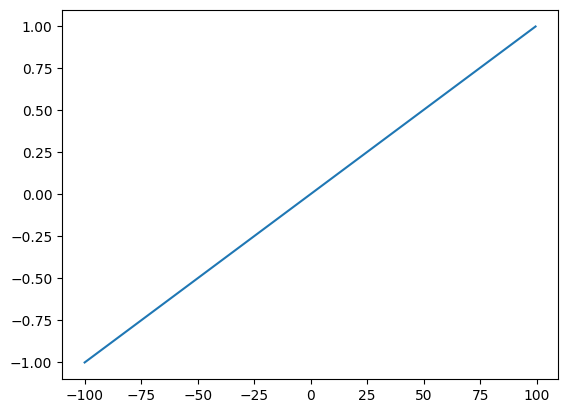

In [ ]:
sequence = np.arange(-100.0, 100, 0.5)
new_sequence = (2 * (sequence - sequence.min()) / 
        (sequence.max() - sequence.min()) - 1)

plt.plot(sequence, new_sequence)
plt.show()


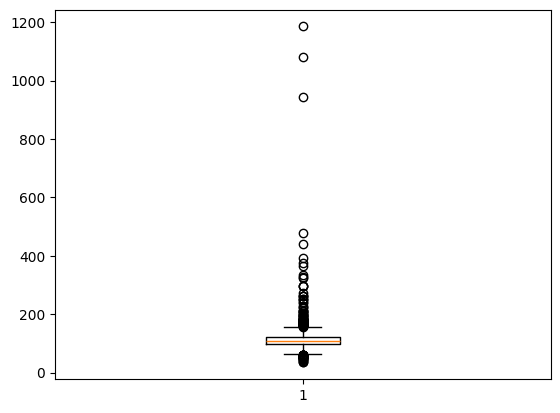

In [22]:
plt.boxplot(x = gdp['2021'])
plt.show()